# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 15:07 - loss: 0.6925

  18/1875 [..............................] - ETA: 5s - loss: 0.5896   

  43/1875 [..............................] - ETA: 4s - loss: 0.4896

  68/1875 [>.............................] - ETA: 4s - loss: 0.4402

  87/1875 [>.............................] - ETA: 4s - loss: 0.4161

 109/1875 [>.............................] - ETA: 4s - loss: 0.3955

 140/1875 [=>............................] - ETA: 3s - loss: 0.3744

 166/1875 [=>............................] - ETA: 3s - loss: 0.3608

 193/1875 [==>...........................] - ETA: 3s - loss: 0.3491

 221/1875 [==>...........................] - ETA: 3s - loss: 0.3388

 250/1875 [===>..........................] - ETA: 3s - loss: 0.3296

 278/1875 [===>..........................] - ETA: 3s - loss: 0.3218

 308/1875 [===>..........................] - ETA: 3s - loss: 0.3143

 337/1875 [====>.........................] - ETA: 3s - loss: 0.3078

 366/1875 [====>.........................] - ETA: 2s - loss: 0.3020

 394/1875 [=====>........................] - ETA: 2s - loss: 0.2968

 418/1875 [=====>........................] - ETA: 2s - loss: 0.2927

 447/1875 [======>.......................] - ETA: 2s - loss: 0.2881

 477/1875 [======>.......................] - ETA: 2s - loss: 0.2836

 507/1875 [=======>......................] - ETA: 2s - loss: 0.2795

 537/1875 [=======>......................] - ETA: 2s - loss: 0.2757

 567/1875 [========>.....................] - ETA: 2s - loss: 0.2720

 597/1875 [========>.....................] - ETA: 2s - loss: 0.2687

 627/1875 [=========>....................] - ETA: 2s - loss: 0.2655

 657/1875 [=========>....................] - ETA: 2s - loss: 0.2624

 682/1875 [=========>....................] - ETA: 2s - loss: 0.2600

 710/1875 [==========>...................] - ETA: 2s - loss: 0.2574

 741/1875 [==========>...................] - ETA: 2s - loss: 0.2547

 771/1875 [===========>..................] - ETA: 2s - loss: 0.2522

 802/1875 [===========>..................] - ETA: 1s - loss: 0.2498

 834/1875 [============>.................] - ETA: 1s - loss: 0.2473

 865/1875 [============>.................] - ETA: 1s - loss: 0.2451

 895/1875 [=============>................] - ETA: 1s - loss: 0.2430

 926/1875 [=============>................] - ETA: 1s - loss: 0.2409

 956/1875 [==============>...............] - ETA: 1s - loss: 0.2390

 988/1875 [==============>...............] - ETA: 1s - loss: 0.2370

1019/1875 [===============>..............] - ETA: 1s - loss: 0.2351

1049/1875 [===============>..............] - ETA: 1s - loss: 0.2334

1080/1875 [================>.............] - ETA: 1s - loss: 0.2317

1111/1875 [================>.............] - ETA: 1s - loss: 0.2300

1141/1875 [=================>............] - ETA: 1s - loss: 0.2285

1172/1875 [=================>............] - ETA: 1s - loss: 0.2269

1198/1875 [==================>...........] - ETA: 1s - loss: 0.2257

1230/1875 [==================>...........] - ETA: 1s - loss: 0.2241

1259/1875 [===================>..........] - ETA: 1s - loss: 0.2228

1285/1875 [===================>..........] - ETA: 1s - loss: 0.2217

1313/1875 [====================>.........] - ETA: 1s - loss: 0.2204

1343/1875 [====================>.........] - ETA: 0s - loss: 0.2192

1373/1875 [====================>.........] - ETA: 0s - loss: 0.2179

1403/1875 [=====================>........] - ETA: 0s - loss: 0.2167

1431/1875 [=====================>........] - ETA: 0s - loss: 0.2156

1462/1875 [======================>.......] - ETA: 0s - loss: 0.2145

1500/1875 [=======================>......] - ETA: 0s - loss: 0.2131

1533/1875 [=======================>......] - ETA: 0s - loss: 0.2119

1565/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1600/1875 [========================>.....] - ETA: 0s - loss: 0.2096

1634/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1665/1875 [=========================>....] - ETA: 0s - loss: 0.2074

1696/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1729/1875 [==========================>...] - ETA: 0s - loss: 0.2054

1760/1875 [===========================>..] - ETA: 0s - loss: 0.2045

1791/1875 [===========================>..] - ETA: 0s - loss: 0.2036

1825/1875 [============================>.] - ETA: 0s - loss: 0.2026

1856/1875 [============================>.] - ETA: 0s - loss: 0.2017

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2012


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1112

  25/1875 [..............................] - ETA: 3s - loss: 0.1099

  59/1875 [..............................] - ETA: 3s - loss: 0.1106

  91/1875 [>.............................] - ETA: 3s - loss: 0.1108

 123/1875 [>.............................] - ETA: 2s - loss: 0.1108

 158/1875 [=>............................] - ETA: 2s - loss: 0.1106

 198/1875 [==>...........................] - ETA: 2s - loss: 0.1105

 236/1875 [==>...........................] - ETA: 2s - loss: 0.1103

 274/1875 [===>..........................] - ETA: 2s - loss: 0.1101

 304/1875 [===>..........................] - ETA: 2s - loss: 0.1100

 334/1875 [====>.........................] - ETA: 2s - loss: 0.1098

 368/1875 [====>.........................] - ETA: 2s - loss: 0.1097

 402/1875 [=====>........................] - ETA: 2s - loss: 0.1095

 437/1875 [=====>........................] - ETA: 2s - loss: 0.1094

 473/1875 [======>.......................] - ETA: 2s - loss: 0.1093

 508/1875 [=======>......................] - ETA: 2s - loss: 0.1092

 538/1875 [=======>......................] - ETA: 2s - loss: 0.1091

 570/1875 [========>.....................] - ETA: 1s - loss: 0.1090

 604/1875 [========>.....................] - ETA: 1s - loss: 0.1088

 638/1875 [=========>....................] - ETA: 1s - loss: 0.1087

 673/1875 [=========>....................] - ETA: 1s - loss: 0.1086

 709/1875 [==========>...................] - ETA: 1s - loss: 0.1085

 746/1875 [==========>...................] - ETA: 1s - loss: 0.1084

 784/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 822/1875 [============>.................] - ETA: 1s - loss: 0.1082

 861/1875 [============>.................] - ETA: 1s - loss: 0.1081

 898/1875 [=============>................] - ETA: 1s - loss: 0.1080

 936/1875 [=============>................] - ETA: 1s - loss: 0.1079

 974/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1009/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1045/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1082/1875 [================>.............] - ETA: 1s - loss: 0.1076

1119/1875 [================>.............] - ETA: 1s - loss: 0.1075

1157/1875 [=================>............] - ETA: 1s - loss: 0.1074

1193/1875 [==================>...........] - ETA: 0s - loss: 0.1073

1229/1875 [==================>...........] - ETA: 0s - loss: 0.1072

1266/1875 [===================>..........] - ETA: 0s - loss: 0.1072

1303/1875 [===================>..........] - ETA: 0s - loss: 0.1071

1340/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1378/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1415/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1453/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1490/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1527/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1564/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1603/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1638/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1673/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1709/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1745/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1782/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1818/1875 [============================>.] - ETA: 0s - loss: 0.1061

1853/1875 [============================>.] - ETA: 0s - loss: 0.1060

1875/1875 [==============================] - 3s 1ms/step - loss: 0.1060


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0910

  39/1875 [..............................] - ETA: 2s - loss: 0.1003

  75/1875 [>.............................] - ETA: 2s - loss: 0.0998

 109/1875 [>.............................] - ETA: 2s - loss: 0.0995

 145/1875 [=>............................] - ETA: 2s - loss: 0.0993

 181/1875 [=>............................] - ETA: 2s - loss: 0.0991

 217/1875 [==>...........................] - ETA: 2s - loss: 0.0990

 253/1875 [===>..........................] - ETA: 2s - loss: 0.0989

 289/1875 [===>..........................] - ETA: 2s - loss: 0.0988

 325/1875 [====>.........................] - ETA: 2s - loss: 0.0988

 362/1875 [====>.........................] - ETA: 2s - loss: 0.0988

 397/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 433/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 470/1875 [======>.......................] - ETA: 1s - loss: 0.0987

 507/1875 [=======>......................] - ETA: 1s - loss: 0.0987

 544/1875 [=======>......................] - ETA: 1s - loss: 0.0986

 582/1875 [========>.....................] - ETA: 1s - loss: 0.0986

 620/1875 [========>.....................] - ETA: 1s - loss: 0.0986

 659/1875 [=========>....................] - ETA: 1s - loss: 0.0986

 697/1875 [==========>...................] - ETA: 1s - loss: 0.0986

 731/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 763/1875 [===========>..................] - ETA: 1s - loss: 0.0985

 796/1875 [===========>..................] - ETA: 1s - loss: 0.0985

 830/1875 [============>.................] - ETA: 1s - loss: 0.0985

 866/1875 [============>.................] - ETA: 1s - loss: 0.0984

 904/1875 [=============>................] - ETA: 1s - loss: 0.0984

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0984

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0984

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1080/1875 [================>.............] - ETA: 1s - loss: 0.0983

1118/1875 [================>.............] - ETA: 1s - loss: 0.0983

1157/1875 [=================>............] - ETA: 1s - loss: 0.0983

1196/1875 [==================>...........] - ETA: 0s - loss: 0.0983

1231/1875 [==================>...........] - ETA: 0s - loss: 0.0982

1268/1875 [===================>..........] - ETA: 0s - loss: 0.0982

1306/1875 [===================>..........] - ETA: 0s - loss: 0.0982

1344/1875 [====================>.........] - ETA: 0s - loss: 0.0982

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0982

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0982

1455/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0981

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1719/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1795/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1833/1875 [============================>.] - ETA: 0s - loss: 0.0980

1870/1875 [============================>.] - ETA: 0s - loss: 0.0980

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0980


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1010

  38/1875 [..............................] - ETA: 2s - loss: 0.0944

  71/1875 [>.............................] - ETA: 2s - loss: 0.0949

 106/1875 [>.............................] - ETA: 2s - loss: 0.0952

 142/1875 [=>............................] - ETA: 2s - loss: 0.0954

 180/1875 [=>............................] - ETA: 2s - loss: 0.0954

 218/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 255/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 290/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 324/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 358/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 428/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 498/1875 [======>.......................] - ETA: 1s - loss: 0.0956

 536/1875 [=======>......................] - ETA: 1s - loss: 0.0957

 575/1875 [========>.....................] - ETA: 1s - loss: 0.0957

 612/1875 [========>.....................] - ETA: 1s - loss: 0.0957

 650/1875 [=========>....................] - ETA: 1s - loss: 0.0957

 687/1875 [=========>....................] - ETA: 1s - loss: 0.0958

 719/1875 [==========>...................] - ETA: 1s - loss: 0.0958

 755/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 790/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 826/1875 [============>.................] - ETA: 1s - loss: 0.0958

 864/1875 [============>.................] - ETA: 1s - loss: 0.0958

 904/1875 [=============>................] - ETA: 1s - loss: 0.0958

 935/1875 [=============>................] - ETA: 1s - loss: 0.0958

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1008/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1084/1875 [================>.............] - ETA: 1s - loss: 0.0958

1120/1875 [================>.............] - ETA: 1s - loss: 0.0958

1156/1875 [=================>............] - ETA: 1s - loss: 0.0958

1195/1875 [==================>...........] - ETA: 0s - loss: 0.0958

1233/1875 [==================>...........] - ETA: 0s - loss: 0.0958

1270/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1307/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1345/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1825/1875 [============================>.] - ETA: 0s - loss: 0.0959

1858/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0880

  39/1875 [..............................] - ETA: 2s - loss: 0.0947

  76/1875 [>.............................] - ETA: 2s - loss: 0.0950

 114/1875 [>.............................] - ETA: 2s - loss: 0.0952

 150/1875 [=>............................] - ETA: 2s - loss: 0.0953

 185/1875 [=>............................] - ETA: 2s - loss: 0.0954

 221/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 257/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 294/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 329/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 442/1875 [======>.......................] - ETA: 1s - loss: 0.0955

 478/1875 [======>.......................] - ETA: 1s - loss: 0.0955

 515/1875 [=======>......................] - ETA: 1s - loss: 0.0955

 553/1875 [=======>......................] - ETA: 1s - loss: 0.0955

 590/1875 [========>.....................] - ETA: 1s - loss: 0.0955

 627/1875 [=========>....................] - ETA: 1s - loss: 0.0955

 664/1875 [=========>....................] - ETA: 1s - loss: 0.0955

 701/1875 [==========>...................] - ETA: 1s - loss: 0.0955

 738/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 774/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 812/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 843/1875 [============>.................] - ETA: 1s - loss: 0.0954

 877/1875 [=============>................] - ETA: 1s - loss: 0.0954

 912/1875 [=============>................] - ETA: 1s - loss: 0.0954

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 979/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1086/1875 [================>.............] - ETA: 1s - loss: 0.0954

1121/1875 [================>.............] - ETA: 1s - loss: 0.0954

1157/1875 [=================>............] - ETA: 1s - loss: 0.0954

1196/1875 [==================>...........] - ETA: 0s - loss: 0.0954

1234/1875 [==================>...........] - ETA: 0s - loss: 0.0954

1271/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1308/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1344/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1827/1875 [============================>.] - ETA: 0s - loss: 0.0954

1865/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

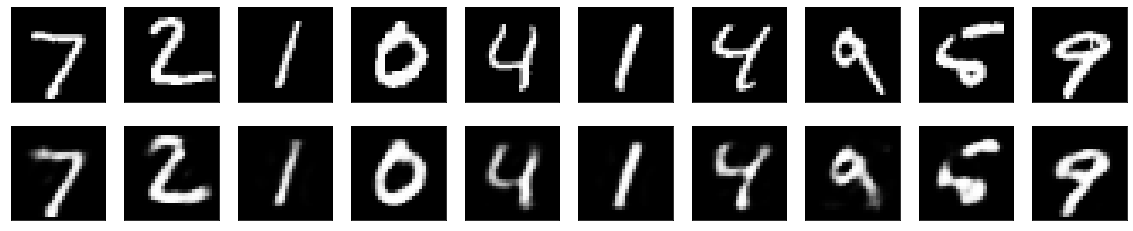

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
